```{contents}
```

## LSTM

**LSTM (Long Short-Term Memory)** is a type of **Recurrent Neural Network (RNN)** designed to overcome the **vanishing/exploding gradient problem** that limits standard RNNs when learning long-term dependencies.

---

### 1. **Intuition**

* Standard RNNs remember information for short spans. When sequences are long, earlier information fades.
* LSTMs solve this by introducing a **cell state** — a “conveyor belt” that carries information unchanged across many time steps, with controlled additions/removals through **gates**.
* The gates decide what to keep, what to forget, and what to output.

So:

* **Forget Gate** → What information to erase
* **Input Gate** → What new information to store
* **Output Gate** → What to reveal to the next layer or output

---

![alt text](../../images/lstm.png)


### 2. **Mathematical Workflow**

Let:

* $x_t$: input at time *t*
* $h_{t-1}$: previous hidden state
* $C_{t-1}$: previous cell state
* $W$: weight matrices, $b$: biases
* $\sigma$: sigmoid function, $\tanh$: hyperbolic tangent

---

**Step 1: Forget gate**

$$
f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)
$$

Determines how much of the previous cell state to forget.

---

**Step 2: Input gate**

$$
i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}*t = \tanh(W_C [h*{t-1}, x_t] + b_C)
$$

Decides what new information to add to the cell state.

---

**Step 3: Update cell state**

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

Combines old and new information.

---

**Step 4: Output gate**

$$
o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$

Controls what information becomes the new hidden state (output).

---

### 3. **Workflow Summary**

| Step | Gate        | Function                   | Output               |
| ---- | ----------- | -------------------------- | -------------------- |
| 1    | Forget      | Remove irrelevant memory   | $f_t$              |
| 2    | Input       | Add relevant new info      | $i_t, \tilde{C}_t$ |
| 3    | Cell Update | Combine memories           | $C_t$              |
| 4    | Output      | Generate next hidden state | $h_t$              |

---

### 4. **Intuitive Analogy**

Think of LSTM as a **smart notebook**:

* You **erase** outdated notes (forget gate).
* You **write** new important facts (input gate).
* You **read** only the relevant parts when needed (output gate).

---

### 5. **Applications**

* Time series forecasting
* Text generation and translation
* Speech recognition
* Anomaly detection


**LSTM vs Standard RNN — Core Difference and Trade-offs**

---

### 1. **Core Difference**

| Feature                     | Standard RNN                                      | LSTM                                                        |
| --------------------------- | ------------------------------------------------- | ----------------------------------------------------------- |
| **Memory**                  | Only short-term (hidden state (h_t))              | Long-term via **cell state (C_t)**                          |
| **Information control**     | No mechanism to choose what to remember or forget | Uses **gates** (forget, input, output) for selective memory |
| **Gradient flow**           | Prone to **vanishing/exploding gradients**        | Cell state enables **constant error flow** across time      |
| **Architecture complexity** | Simple (1 layer of weights)                       | Complex (multiple gates, more parameters)                   |

---

### 2. **Advantages of LSTM**

| Advantage                          | Explanation                                                                       |
| ---------------------------------- | --------------------------------------------------------------------------------- |
| **Long-term dependency learning**  | Retains relevant past information across many time steps.                         |
| **Stable gradient flow**           | Gates and cell state reduce vanishing/exploding gradients during backpropagation. |
| **Selective memory**               | Learns to forget or retain info dynamically.                                      |
| **Effective on complex sequences** | Excels in NLP, speech, and time-series problems.                                  |

---

### 3. **Disadvantages of LSTM**

| Disadvantage                | Explanation                                              |
| --------------------------- | -------------------------------------------------------- |
| **High computational cost** | Four weight matrices and gate activations per time step. |
| **Slower training**         | More parameters → slower convergence.                    |
| **Overfitting risk**        | More parameters need regularization and dropout.         |
| **Harder to interpret**     | Gate dynamics make internal logic opaque.                |

---

### 4. **Summary of Differences**

| Aspect             | RNN                    | LSTM                              |
| ------------------ | ---------------------- | --------------------------------- |
| Memory length      | Short                  | Long                              |
| Gradient stability | Unstable               | Stable                            |
| Computation cost   | Low                    | High                              |
| Suitability        | Simple short sequences | Long, context-dependent sequences |

---

### 5. **Alternatives / Evolutions**

| Model                          | Improvement                                                 |
| ------------------------------ | ----------------------------------------------------------- |
| **GRU (Gated Recurrent Unit)** | Simplified LSTM (fewer gates, faster)                       |
| **BiLSTM**                     | Two LSTMs, forward and backward, for full context           |
| **Transformers**               | Replace recurrence with attention, faster and more scalable |

---

In short:

* **RNN** = Simple but forgetful.
* **LSTM** = Powerful memory, slower.
* **GRU** = Middle ground.
* **Transformer** = Memory-free, uses attention, now dominant.


### Demonstration 

In [1]:
# Install dependencies (if needed)
# !pip install tensorflow scikit-learn matplotlib pandas numpy

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt


#### **Cell 2 — Generate Synthetic Time Series Data**


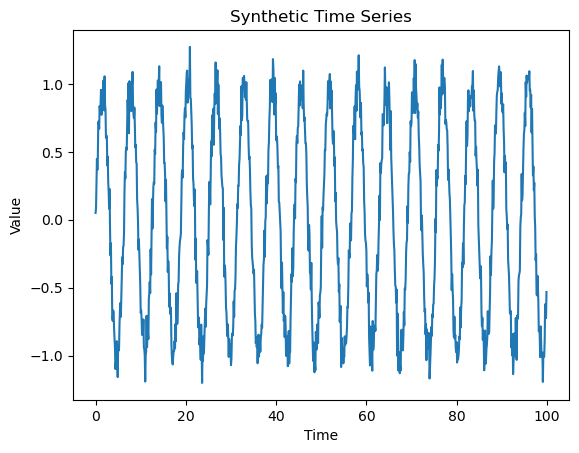

In [6]:
np.random.seed(42)
time = np.arange(0, 100, 0.1)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))

plt.plot(time, data)
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


#### **Cell 3 — Prepare Dataset**

In [3]:

window_size = 20
X, y = [], []

for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    y.append(data[i + window_size])

X = np.array(X).reshape(-1, window_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 784, Test samples: 196


#### 🧩 **Cell 4 — Define Hyperparameter Grid and Callbacks**

In [4]:


batch_sizes = [16, 32]
learning_rates = [0.001, 0.005]
dropouts = [0.1, 0.3]

# Learning rate schedule function
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * 0.9  # decay rate
    return lr

# Early stopping: stop if val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#### **Cell 5 — Train and Evaluate Models**


In [7]:
results = []

for batch_size, lr, dropout_rate in itertools.product(batch_sizes, learning_rates, dropouts):
    model = Sequential([
        LSTM(50, input_shape=(window_size, 1)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
    )

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results.append((batch_size, lr, dropout_rate, test_loss))

results_df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Dropout", "Test Loss"])
results_df


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,Batch Size,Learning Rate,Dropout,Test Loss
0,16,0.001,0.1,0.011238
1,16,0.001,0.3,0.011864
2,16,0.005,0.1,0.012214
3,16,0.005,0.3,0.012350
4,32,0.001,0.1,0.011378
5,32,0.001,0.3,0.011437
6,32,0.005,0.1,0.011219
7,32,0.005,0.3,0.011981



#### **Cell 6 — Select Best Configuration**

In [10]:

best_config = results_df.loc[results_df["Test Loss"].idxmin()]
print("Best Configuration:")
print(best_config)


Best Configuration:
Batch Size       32.000000
Learning Rate     0.005000
Dropout           0.100000
Test Loss         0.011219
Name: 6, dtype: float64



### 🧩 **Cell 7 — Retrain Best Model and Visualize Predictions**


Epoch 1/50


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1608 - val_loss: 0.0176 - learning_rate: 0.0050
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0204 - val_loss: 0.0133 - learning_rate: 0.0050
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0171 - val_loss: 0.0131 - learning_rate: 0.0050
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0170 - val_loss: 0.0132 - learning_rate: 0.0050
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0167 - val_loss: 0.0138 - learning_rate: 0.0050
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178 - val_loss: 0.0154 - learning_rate: 0.0050
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0177 - learning_rate: 0.0050
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - val_loss: 0.0126 - learning_rate: 0.0050
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0179 - val_loss: 0.0146 - learning_rate: 0.0050
Epoch 10/50
23/23 ━━━━━━━━━━━━

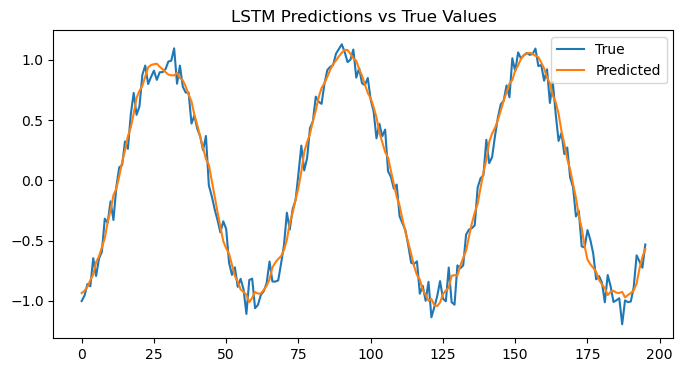

In [9]:
best_batch = int(best_config["Batch Size"])
best_lr = float(best_config["Learning Rate"])
best_dropout = float(best_config["Dropout"])

best_model = Sequential([
    LSTM(50, input_shape=(window_size, 1)),
    Dropout(best_dropout),
    Dense(1)
])
best_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))

history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
)

preds = best_model.predict(X_test)

plt.figure(figsize=(8,4))
plt.plot(y_test, label="True")
plt.plot(preds, label="Predicted")
plt.title("LSTM Predictions vs True Values")
plt.legend()
plt.show()


---

**What’s New Here**

| Feature                   | Purpose                                                                     |
| ------------------------- | --------------------------------------------------------------------------- |
| **EarlyStopping**         | Stops training when validation loss stops improving (prevents overfitting). |
| **LearningRateScheduler** | Gradually reduces learning rate after 10 epochs (faster convergence).       |
| **Best Config Selection** | Automatically identifies the best performing hyperparameters.               |

